<a href="https://www.kaggle.com/code/aritra423/calorie-predictor-2?scriptVersionId=240254399" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")

In [3]:
from sklearn.preprocessing import LabelEncoder
numerical_features = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]

def add_feature_cross_terms(df, numerical_features):
    df_new = df.copy()

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            f1 = numerical_features[i]
            f2 = numerical_features[j]
            df_new[f"{f1}_x_{f2}"] = df_new[f1] * df_new[f2]
            df_new[f"{f1}_add_{f2}"] = df_new[f1] + df_new[f2]
            df_new[f"{f1}_div_{f2}"] = df_new[f1] / (df_new[f2] + 1e-6)

    return df_new

train = add_feature_cross_terms(train, numerical_features)
test = add_feature_cross_terms(test, numerical_features)

le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.transform(test['Sex'])

/tmp/ipykernel_19/2532691918.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2532691918.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2532691918.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2532691918.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2532691918.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


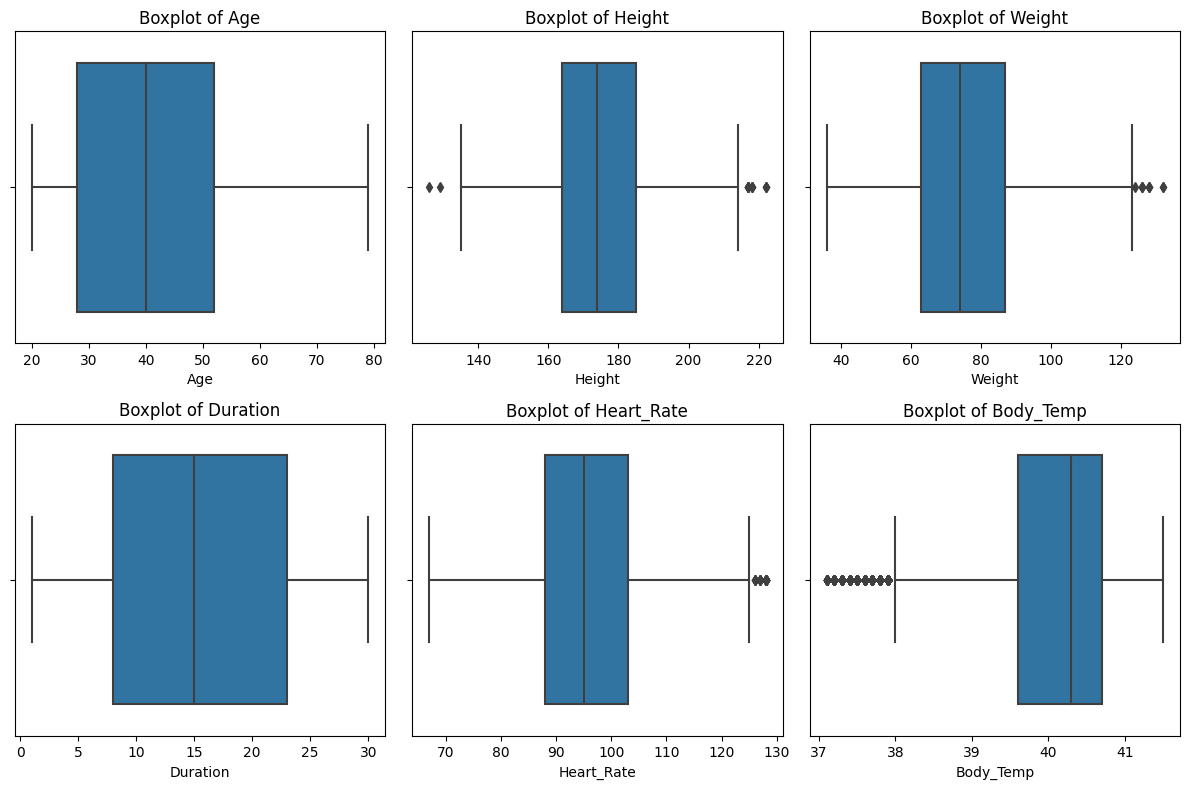

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]

plt.figure(figsize=(12, 8))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(data=train, x=feature)
    plt.title(f'Boxplot of {feature}')
    plt.tight_layout()

plt.show()

In [5]:
from sklearn.model_selection import train_test_split
X = train.drop(columns=["id", "Calories"])
y = np.log1p(train["Calories"])  
X_test = test.drop(columns=["id"])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_log_error

model_xg = XGBRegressor(
    objective='reg:squarederror',  
    tree_method='gpu_hist',           # GPU histogram algorithm
    predictor='gpu_predictor',        # GPU-based prediction
    random_state=42,
    verbosity=0                       # Suppress training logs
)

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2],
}

msle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
random_search = RandomizedSearchCV(
    estimator=model_xg,
    param_distributions=param_dist,
    n_iter=50,                # Number of random combinations to try
    scoring=msle_scorer,      # Negative MSLE (because lower is better)
    cv=3,                     # 3-fold cross-validation
    verbose=0,                # No progress output
    random_state=42,
    n_jobs=-1                 
)
random_search.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          predictor='gpu_predictor', ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(mean_squared_log_error, greater_is_better=False))

In [7]:
best_msle = -random_search.best_score_  
print(f"Best Mean Squared Log Error: {best_msle:.5f}")
print("Best hyperparameters:")
print(random_search.best_params_)

Best Mean Squared Log Error: 0.00030
Best hyperparameters:
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


Mean Log Squared Error (MSLE): 0.00360


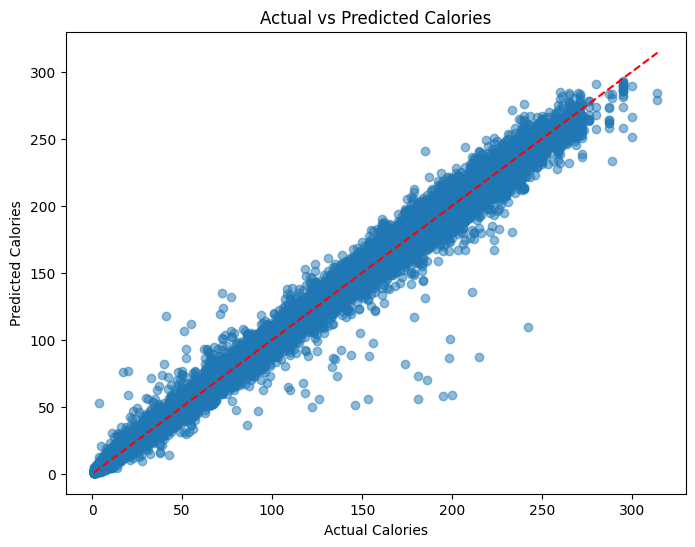

In [8]:
from sklearn.metrics import mean_squared_log_error

y_pred = random_search.best_estimator_.predict(X_valid)
y_valid_exp = np.expm1(y_valid)
y_pred_exp = np.expm1(y_pred)

# Calculate MSLE
msle_value = mean_squared_log_error(y_valid_exp, y_pred_exp)
print(f"Mean Log Squared Error (MSLE): {msle_value:.5f}")

# Scatter plot of actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y_valid_exp, y_pred_exp, alpha=0.5)
plt.plot([y_valid_exp.min(), y_valid_exp.max()], [y_valid_exp.min(), y_valid_exp.max()], 'r--')  # 45-degree line
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.title('Actual vs Predicted Calories')
plt.show()

In [9]:
y_test_pred = random_search.best_estimator_.predict(X_test)
y_test_pred_final = np.expm1(y_test_pred)  # Only if y = np.log1p(train["Calories"])
submission_df = pd.DataFrame({
    "id": test["id"],
    "Calories": y_test_pred_final
})
submission_df.to_csv("submission.csv", index=False)